# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">Decision tree visualization</span>

In this notebook we show how to plot individual trees with custom metrics.

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
dataset = pd.read_parquet("data/credit_data.parquet")

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

### <span style="font-family: Arial, sans-serif; color: navyblue; font-size: 25px;">Tree visualization</span>

In [2]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=15,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(
    **best_params, random_state=62
)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[
    :, 1
]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[
    :, 1
]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(
    f"Train Gini score: {gini_trn:.2%}\n"
    f"Test Gini score: {gini_tst:.2%}"
)

Train Gini score: 91.20%
Test Gini score: 89.17%


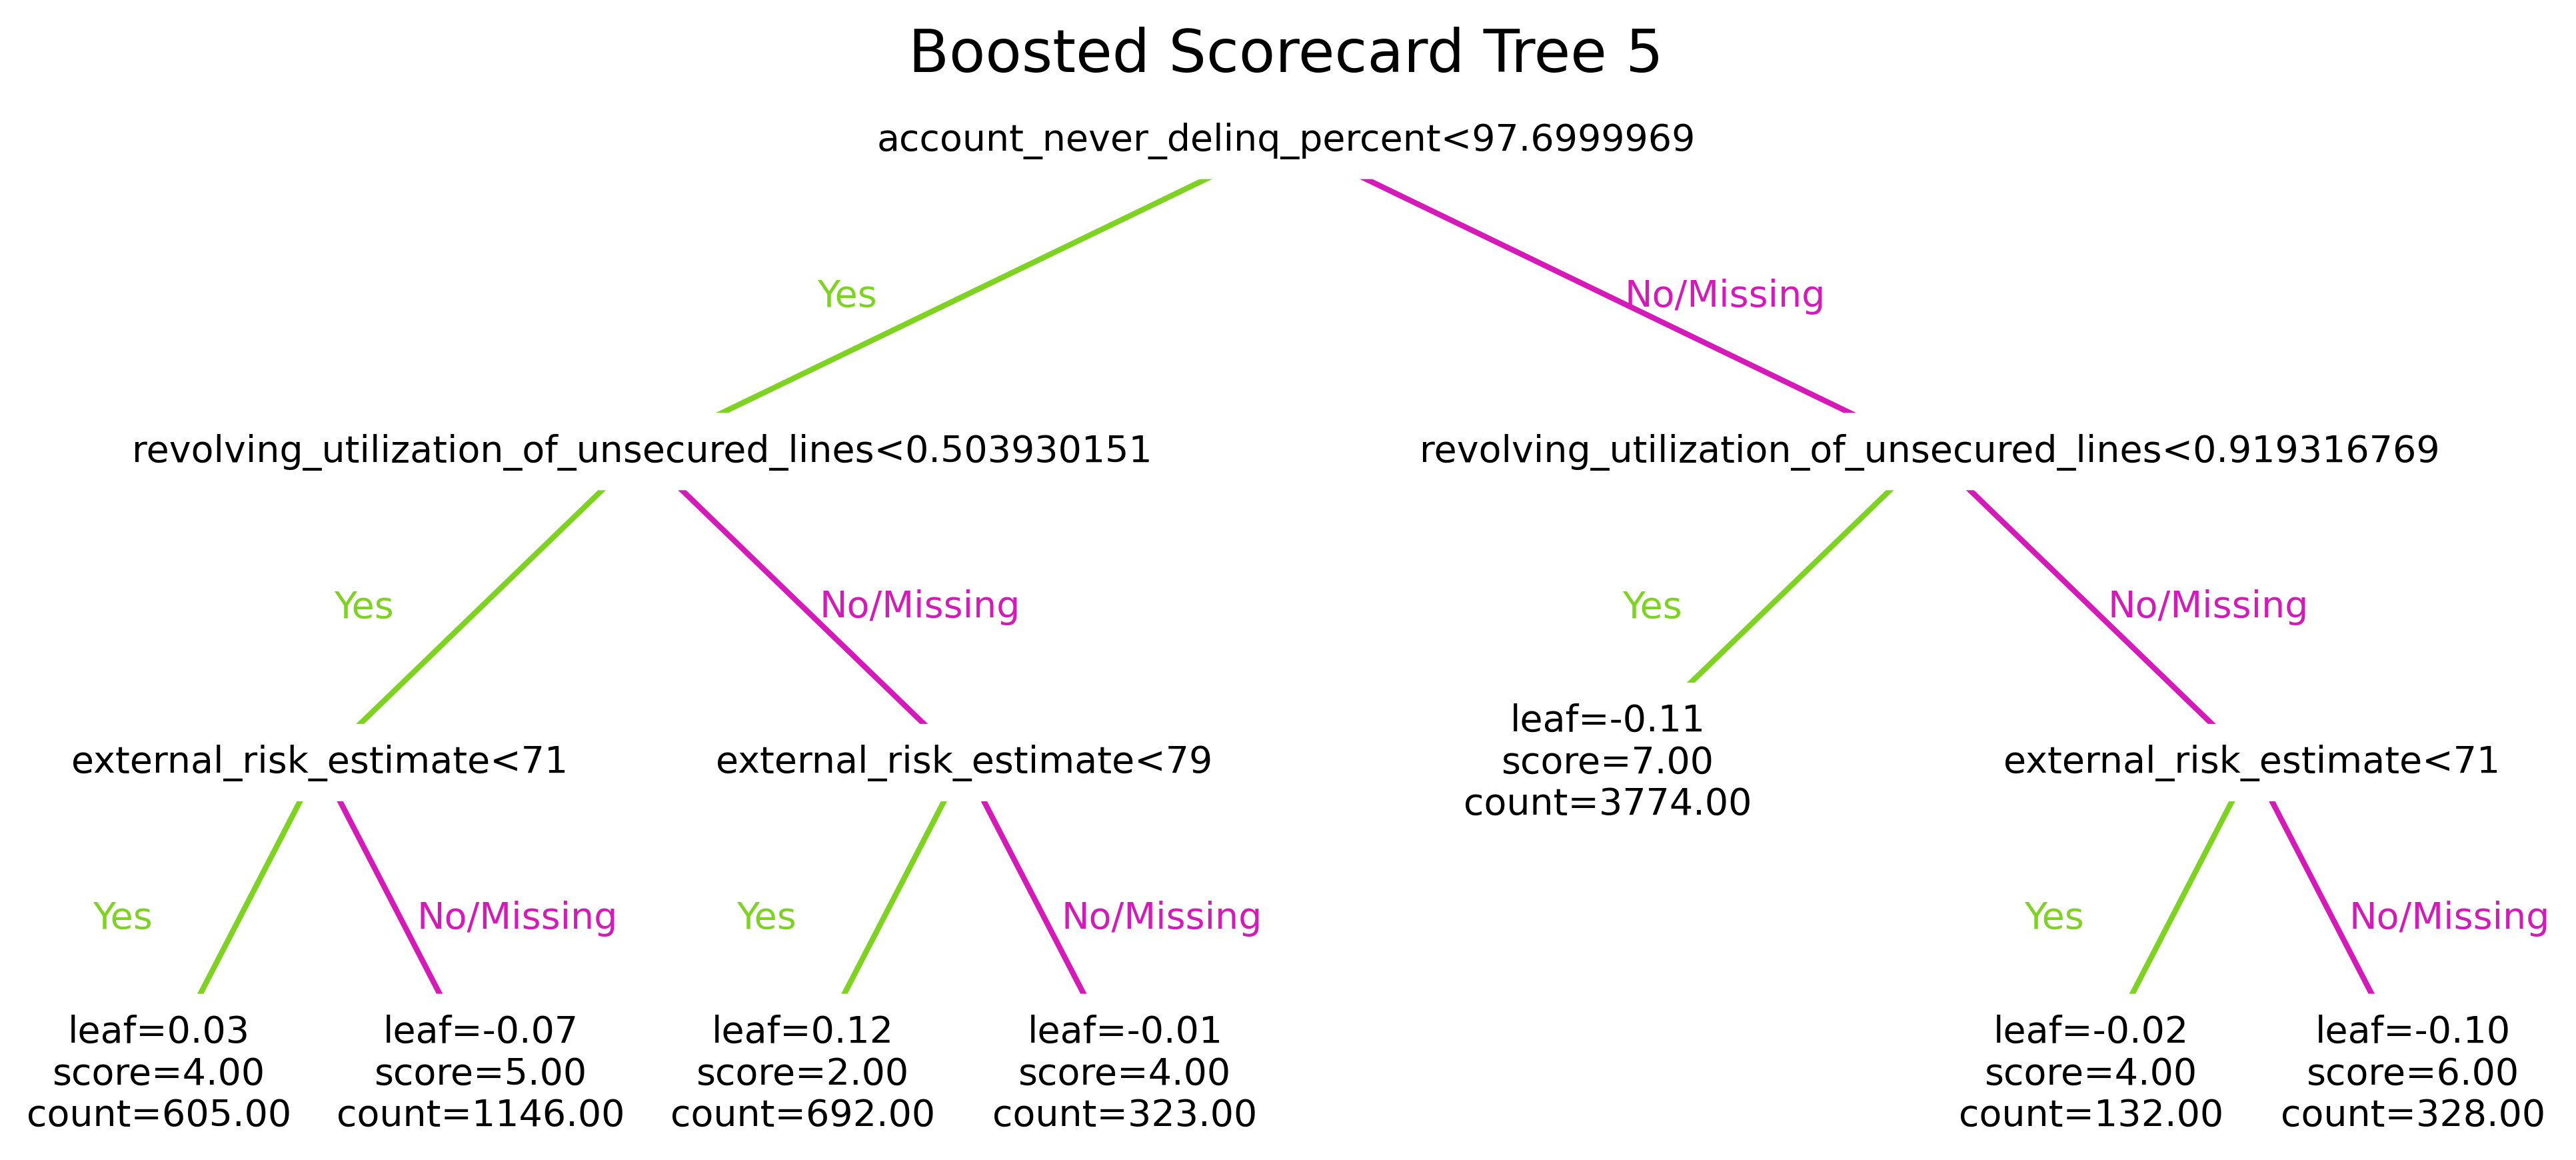

In [5]:
# Import necessary modules
from xbooster.constructor import XGBScorecardConstructor
from matplotlib import pyplot as plt
from xbooster.explainer import TreeVisualizer

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(
    xgb_model, X.loc[ix_train], y.loc[ix_train]
)

scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = (
    scorecard_constructor.create_points(
        pdo=70,
        target_points=600,
        target_odds=9,
        score_type="WOE",
    )
)

tree_viz = TreeVisualizer(
    metrics=["Points", "Count"], precision=2
)

tree_id = 5

plt.figure(figsize=(12, 5), dpi=200)
tree_viz.plot_tree(scorecard_constructor, num_trees=tree_id)
plt.title(f"Boosted Scorecard Tree {tree_id}", fontsize=16)
plt.show()